In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import cv2
from models.murel.networks.MurelNet import MurelNet
from dataset.VQAv2Dataset import VQAv2Dataset
import yaml
import torch
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

/home/bat34/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


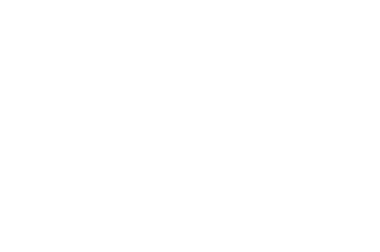

In [2]:
with open('/home/bat34/VQA_PartII/models/murel/configs/murel.yaml') as f:
    config = yaml.load(f)

    
val_dataset = VQAv2Dataset(split="val",
                            txt_enc=config['txt_enc'],
                            bottom_up_features_dir=config['bottom_up_features_dir'],
                            skipthoughts_dir=config['skipthoughts_dir'],
                            processed_dir=config['processed_dir'],
                            ROOT_DIR=config['ROOT_DIR'],
                            vqa_dir=config['vqa_dir'])

val_loader = DataLoader(val_dataset, 
                          shuffle=True,
                          batch_size=1,
                          num_workers=config['num_workers'],
                          collate_fn=val_dataset.collate_fn)

val_iter = iter(val_loader)
x = plt.axis('off')

In [3]:
def load_model_state_dict(model, best_model_name):
    x = torch.load('/local/scratch/bat34/murel_trained_models/evaluation/{}/checkpoint.pth'.format(best_model_name))
    model.load_state_dict(x['model'])
    model.eval()
    return model

In [4]:
model = MurelNet(config, [val_dataset.wid_to_word[i] for i in range(1, len(val_dataset.wid_to_word) + 1)])
best_model_name = 'murel_dropout_corrected_wid_seed_6969_murel_attention_False_loss_function_NLLLoss_txt_enc_BayesianUniSkip_pooling_agg_max_pairwise_agg_max_batch_size_256_lr_0.0003_lr_decay_rate_0.25_unroll_steps_3_fusion_type_block'
model = load_model_state_dict(model, best_model_name)

In [13]:
def adjust_brightness(image, brightness=30, scale=0.2):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v = hsv[:, :, 2]
    hsv[:, :, 2] = v * scale
    res = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return res


def squeeze_tensors(buffer):
    for key in buffer:
        if isinstance(buffer[key], torch.Tensor):
            buffer[key] = torch.squeeze(buffer[key])
        if isinstance(buffer[key], dict):
            buffer[key] = squeeze_tensors(buffer[key])
        if isinstance(buffer[key], list):
            buffer[key] = buffer[key][0]
    return buffer

def get_coords_from_bb(bb, org_img):
    x1, y1, x2, y2 = bb
    x1, x2 = int(x1 * org_img.shape[1]), int(x2 * org_img.shape[1])
    y1, y2 = int(y1 * org_img.shape[0]), int(y2 * org_img.shape[0])
    return x1, y1, x2, y2

def calculate_midpoint(x1, y1, x2, y2):
    return (x1 + x2) // 2, (y1 + y2) // 2

def visualise_murel(model, data, dataset, highlight_pairwise= True, 
                    save=False, save_name=None, threshold=0.2, unroll_steps=3):
    model.initialise_buffers()
    with torch.no_grad():
        output = model(data)
    org_img = cv2.imread('/local/scratch/bat34/val2014/{}'.format(data['image_name'][0]), cv2.IMREAD_COLOR)
    buffer = model.buffer
    _, arg = torch.max(output, dim=1)
    model_ans = dataset.aid_to_ans[arg]
    actual_ans = data['answer'][0]
    question_reconstr = [dataset.wid_to_word[id.item()] for id in list(data['question_ids'][0])]
    question_reconstr = ' '.join(question_reconstr) + '?'
    question_reconstr = question_reconstr.capitalize()
    bounding_boxes = data['bounding_boxes'][0].tolist()
    
    fig, ax = plt.subplots(1, 4, figsize=(30, 10))
    fig.suptitle('Question: {}'.format(question_reconstr) + '\n' + 
             'Model Answer: {}'.format(model_ans) + '\n' + 
             'Actual Answer: {}'.format(actual_ans), fontsize=30)
    
    ax[0].axis('off')
    ax[0].imshow(cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image', fontsize=30)
    
    
    
    for step in range(unroll_steps):
        curr_ax = ax[step + 1]
        curr_ax.axis('off')
        curr_img = org_img.copy()
        curr_img = adjust_brightness(curr_img, scale=0.6)
        gamma_img = curr_img.copy()
        argmax = buffer[step]['argmax'][0].tolist()
        argmax_count = Counter(argmax)
        for i, bb in enumerate(bounding_boxes):
            x1, y1, x2, y2 = get_coords_from_bb(bb, org_img)
            
            sub_img = gamma_img[y1: y2, x1: x2]
            white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
            
            prob = argmax_count[i]/2048
            prob = min(prob* 5, 0.7)
            
            res = cv2.addWeighted(sub_img, 1-prob, white_rect, prob, 1.0)
            curr_img[y1:y2, x1: x2] = np.maximum(curr_img[y1:y2, x1:x2], res)
        
        # I_hat is the region most impacted by pairwise
        # Calculate contrib of each region to e_hat of I_hat, if exceed threshold then highlight that region green,
        # and highlight I_hat red.
        # If no such region that passes threshold, then don't color I_hat.
        if highlight_pairwise is True:
            i_hat = buffer[step]['i_hat'].item()
            r = buffer[step]['relations'][0][i_hat]
            _, r_arg = torch.max(r, dim=0)
            r_arg = r_arg.tolist()
            r_count = Counter(r_arg)
            r_contrib = [r_count[i]/2048 for i in range(36)]
            r_sigf = [i for i in range(36) if r_contrib[i] >= threshold]
            if r_sigf:
                x1_hat, y1_hat, x2_hat, y2_hat = get_coords_from_bb(bounding_boxes[i_hat], org_img)
                if len(r_sigf) > 1 or r_sigf[0] != i_hat:
                    curr_img = cv2.rectangle(curr_img, (x1_hat, y1_hat), (x2_hat, y2_hat), (0, 255, 0), 3)
                for reg_id in r_sigf:
                    if reg_id == i_hat:
                        continue
                    x1, y1, x2, y2 = get_coords_from_bb(bounding_boxes[reg_id], org_img)
                    curr_img = cv2.arrowedLine(curr_img, 
                                               (calculate_midpoint(x1, y1, x2, y2)), 
                                               (calculate_midpoint(x1_hat, y1_hat, x2_hat, y2_hat)),
                                               (0, 255, 0), 
                                               3, 
                                               cv2.LINE_AA)
                    curr_img = cv2.rectangle(curr_img, (x1, y1), (x2, y2), (0, 0, 255), 3)
        
                
            
        curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB)
        curr_ax.imshow(curr_img)
        curr_ax.set_title('Step: {}'.format(step + 1), fontsize=30)
    fig.tight_layout()
    if save is True and save_name is not None:
        print('Saving fig to: {}'.format(save_name))
        plt.savefig(save_name, format='png', pad_inches=0, bbox_inches='tight')
        print('Save completed.')
    plt.show()

    

In [60]:
data = val_iter.next()

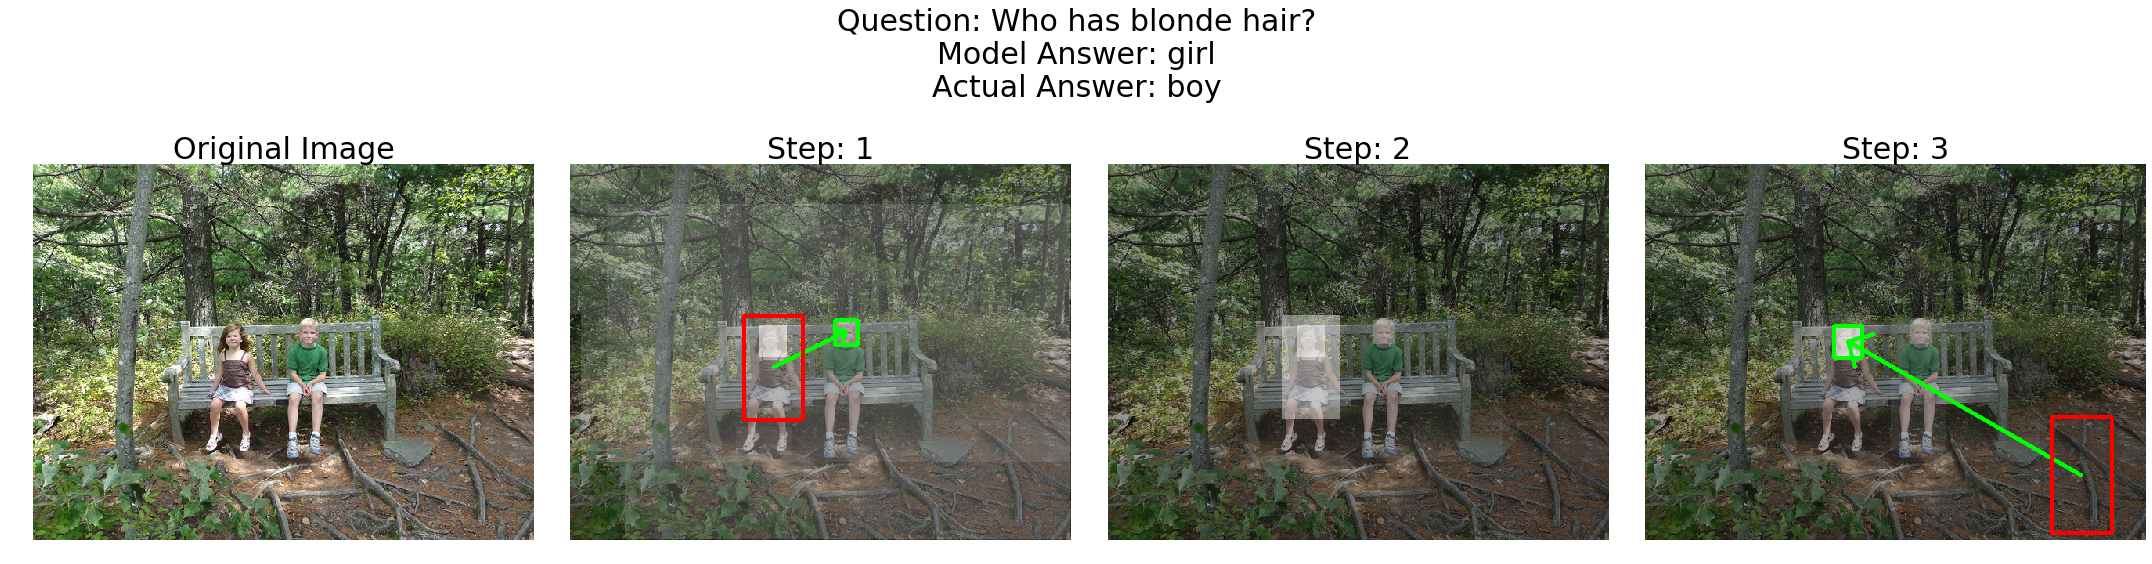

In [61]:
#save = True
#save_name = '/local/scratch/bat34/diss_imgs/val_yamaha_no_highlight_box_correct_ans_{}_index_{}.png'.format(data['image_name'][0], data['index'][0])
highlight_pairwise = True
#highlight_pairwise = False
save = False
save_name = None
visualise_murel(model, data, val_dataset, save=save, save_name=save_name, highlight_pairwise=highlight_pairwise)

In [275]:
val_dataset[171965]

{'answer': 'wii',
 'answer_id': tensor([50]),
 'bounding_boxes': tensor([[0.0000, 0.0000, 0.2917, 0.7714],
         [0.5597, 0.8353, 0.7612, 0.9983],
         [0.5441, 0.0644, 0.7297, 0.4914],
         [0.4720, 0.2826, 0.7618, 0.8818],
         [0.2429, 0.2833, 0.3399, 0.3928],
         [0.0000, 0.0000, 0.8785, 0.5611],
         [0.0000, 0.5736, 0.5048, 0.9983],
         [0.4175, 0.0000, 0.8215, 0.8109],
         [0.0321, 0.7269, 0.4763, 0.9983],
         [0.4354, 0.2304, 0.7466, 0.8070],
         [0.7908, 0.0000, 0.9986, 0.1515],
         [0.2364, 0.2670, 0.3395, 0.3579],
         [0.2230, 0.3851, 0.9986, 0.9983],
         [0.0293, 0.0000, 0.1230, 0.2919],
         [0.1818, 0.0604, 0.8171, 0.9785],
         [0.3076, 0.2663, 0.8691, 0.9983],
         [0.3613, 0.0000, 0.7557, 0.9983],
         [0.2013, 0.0000, 0.6096, 0.9983],
         [0.0599, 0.0000, 0.8940, 0.7471],
         [0.1147, 0.5999, 0.9572, 0.9983],
         [0.2580, 0.3988, 0.2959, 0.4546],
         [0.4732, 0.0564, 0.7396,

In [279]:
model.buffer

{0: {'argmax': tensor([[24,  2, 17,  ..., 24,  6,  9]]),
  'i_hat': tensor([28]),
  'relations': tensor([[[[-0.7822, -1.3587, -0.2461,  ..., -1.3028, -1.5629, -1.1798],
            [-0.4912, -0.7152, -0.1631,  ..., -1.3193, -0.8197, -1.0866],
            [-0.4869, -0.6664, -0.1999,  ..., -1.4210, -0.7623, -1.1286],
            ...,
            [-0.6426, -0.9096, -0.1419,  ..., -1.1097, -1.1521, -1.0667],
            [-0.6814, -1.1732, -0.2429,  ..., -1.3072, -1.3167, -1.1409],
            [-0.7020, -0.5480, -0.1634,  ..., -1.2238, -0.6290, -0.9938]],
  
           [[-0.8455, -1.3219, -0.2890,  ..., -1.1214, -1.5875, -1.0175],
            [-0.7707, -1.0933, -0.2537,  ..., -1.4381, -1.1225, -0.9646],
            [-0.7910, -0.9643, -0.3055,  ..., -1.5398, -1.0020, -1.0009],
            ...,
            [-0.7835, -1.0256, -0.2368,  ..., -1.1221, -1.3579, -0.9027],
            [-0.8079, -1.2724, -0.3036,  ..., -1.2292, -1.5015, -0.9773],
            [-0.9234, -0.7730, -0.3369,  ..., -1.3343

In [282]:
model.buffer[0]['i_hat'].item()

28

In [299]:
data = val_loader.collate_fn([val_dataset[171965]])

In [298]:
data

{'answer': ['wii'],
 'answer_id': tensor([50]),
 'bounding_boxes': tensor([[[0.0000, 0.0000, 0.2917, 0.7714],
          [0.5597, 0.8353, 0.7612, 0.9983],
          [0.5441, 0.0644, 0.7297, 0.4914],
          [0.4720, 0.2826, 0.7618, 0.8818],
          [0.2429, 0.2833, 0.3399, 0.3928],
          [0.0000, 0.0000, 0.8785, 0.5611],
          [0.0000, 0.5736, 0.5048, 0.9983],
          [0.4175, 0.0000, 0.8215, 0.8109],
          [0.0321, 0.7269, 0.4763, 0.9983],
          [0.4354, 0.2304, 0.7466, 0.8070],
          [0.7908, 0.0000, 0.9986, 0.1515],
          [0.2364, 0.2670, 0.3395, 0.3579],
          [0.2230, 0.3851, 0.9986, 0.9983],
          [0.0293, 0.0000, 0.1230, 0.2919],
          [0.1818, 0.0604, 0.8171, 0.9785],
          [0.3076, 0.2663, 0.8691, 0.9983],
          [0.3613, 0.0000, 0.7557, 0.9983],
          [0.2013, 0.0000, 0.6096, 0.9983],
          [0.0599, 0.0000, 0.8940, 0.7471],
          [0.1147, 0.5999, 0.9572, 0.9983],
          [0.2580, 0.3988, 0.2959, 0.4546],
          